In [ ]:
!wget https://nlp.stanford.edu/data/glove.6B.zip

In [ ]:
!unzip glove.6B.zip

In [3]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torch import nn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from datasets import load_dataset
from sklearn.utils import shuffle
%matplotlib inline

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
from datasets import load_dataset
from huggingface_hub import login
from getpass import getpass

# this will pop up a text box. paste the token and press enter.
hf_token = getpass("Paste your Hugging Face access token here: (If you don't have one, create a Hugging Face account!)")
login(token=hf_token)

imdb = load_dataset("imdb", split="train[:10]")
yelp = load_dataset("yelp_polarity", split="train[:20000]")
tweets = load_dataset("MrbBakh/Sentiment140", split="train[:700000]")
emotion = load_dataset("dair-ai/emotion", split="train[:40000]")

print("Tweet columns:", tweets.column_names)
print("Emotion columns:", emotion.column_names)


emotion_text_col = "text"
emotion_label_col = "label"

# remap labels if needed
tweet_label_col = "sentiment"
tweet_labels = [0 if lab == 0 else 1 for lab in tweets[tweet_label_col]]
# Check for the integers 1 (joy), 2 (love), and 5 (surprise)
emotion_labels = [1 if e in [1, 2, 5] else 0 for e in emotion[emotion_label_col]]


texts = (
    list(imdb["text"])
    + list(yelp["text"])
    + list(tweets["text"])
    + list(emotion["text"])
)
labels = (
    list(imdb["label"])
    + list(yelp["label"])
    + tweet_labels
    + emotion_labels
)

texts, labels = shuffle(texts, labels, random_state=42)

split_idx = int(0.9 * len(texts))
train_texts, test_texts = texts[:split_idx], texts[split_idx:]
train_labels, test_labels = labels[:split_idx], labels[split_idx:]

train_texts, test_texts = texts[:split_idx], texts[split_idx:]
train_labels, test_labels = labels[:split_idx], labels[split_idx:]

# training_set = dataset["train"]
# testing_set = dataset["test"]

EDA

In [9]:
train_df = pd.DataFrame({
    "text": train_texts,
    "label": train_labels
})
test_df = pd.DataFrame({
    "text": test_texts,
    "label": test_labels
})

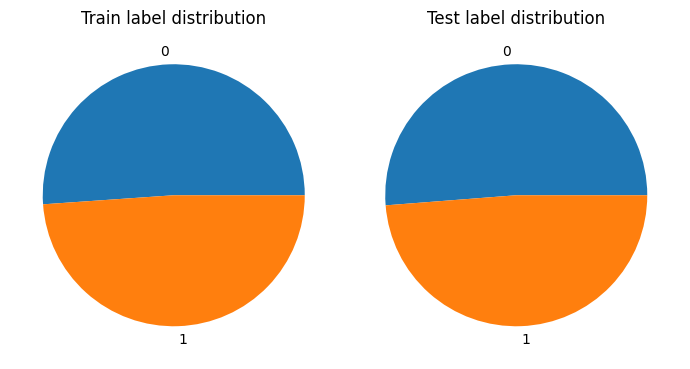

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(7, 7))

train_counts = train_df["label"].value_counts()
test_counts = test_df["label"].value_counts()

axes[0].pie(x=train_counts.values, labels=train_counts.index)
axes[0].set_title("Train label distribution")

axes[1].pie(x=test_counts.values, labels=test_counts.index)
axes[1].set_title("Test label distribution")

plt.tight_layout()
plt.show()

In [11]:
train_df["length"] = train_df["text"].apply(lambda x: len(x.split()))
test_df["length"] = test_df["text"].apply(lambda x: len(x.split()))
train_df, test_df

(                                                    text  label  length
 0      im not joking we had the feeling they were eit...      1      19
 1                                         i feel so cute      1       4
 2      @inevergrewup Oh...good   Thought you didnt' k...      1      14
 3      I typically wouldn't take the time to review a...      0     171
 4      The ladies who were working last night were ex...      1      67
 ...                                                  ...    ...     ...
 68404  big up my mum &amp; my sista 4 making a wickid...      1      12
 68405  @pdxlilly I like that haircut too.  Unfortunat...      0      19
 68406  I judged these ladies to quickly! They have be...      1      23
 68407  i feel the frames could give the works an eleg...      1      29
 68408  Earlier tonight I volunteered as a telethon ph...      1     169
 
 [68409 rows x 3 columns],
                                                    text  label  length
 0              well...

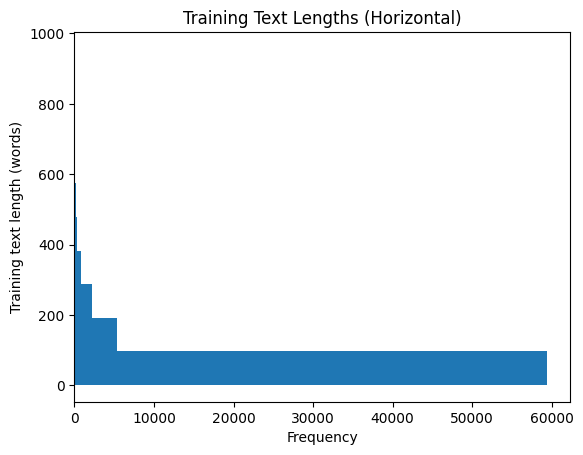

In [12]:
plt.hist(train_df['length'], orientation='horizontal')
plt.xlabel("Frequency")
plt.ylabel("Training text length (words)")
plt.title("Training Text Lengths (Horizontal)")
plt.show()

In [13]:
train_df["length"].describe()

,length
count,68409.000000
mean,44.996828
std,78.680385
min,1.000000
25%,10.000000
50%,18.000000
75%,33.000000
max,956.000000


Emedding and model

In [14]:
# GLOVE PRETRAINED EMBEDDINGS
embedding_index = {}
with open("glove.6B.100d.txt") as file:
    lines = file.readlines()
    for line in lines:
        line = line.split()
        word = line[0]
        embedding = np.array(line[1:], dtype=np.float32)
        embedding_index[word] = embedding

In [ ]:
embedding_index

In [16]:
#CLEAN THE TRAINING DATA
def keep_alphabet(text:str):
    temp = ""
    text = text.replace("<br />", " ")
    for character in text:
        if character.isalpha() or character == " ":
            temp += character
    return temp

In [17]:
import re
def prepare_lists_of_words(text:str):
    # return keep_alphabet(text).lower().split()
    text = re.sub(r"[^a-zA-Z']", " ", text)


    return text.lower().split()

For preparing the dataset

In [18]:
frequency_of_words = {}
def count_freq(words:list):
    for word in words:
        frequency_of_words[word] = frequency_of_words.get(word, 0) + 1

In [19]:
for example in train_texts:
    count_freq(prepare_lists_of_words(example))

In [20]:
frequencies_list = sorted(frequency_of_words.items(), key=lambda x: x[1], reverse=True) #frequency of each word in all our training examples

word_to_index = {items[0]:index for index, items in enumerate(frequencies_list, start=2) if items[1] > 5} #start at 2 to leave space for padding and UNK
word_to_index["<PAD>"] = 0
word_to_index["<UNK>"] = 1

list(word_to_index.items())[:5] #our word to index dict

[('the', 2), ('i', 3), ('and', 4), ('to', 5), ('a', 6)]

Setting up the embedding matrix

In [21]:
UNK = np.random.rand(1,100)
PAD = np.zeros((1,100),dtype=np.float32)

embedding_matrix = np.zeros((len(word_to_index), 100)) #num words x 100 (embedding size)
embedding_matrix[0] = PAD # set up the <PAD>
embedding_matrix[1] = UNK # set up the <UNK>

for word, index in word_to_index.items():

    if index < 2: continue

    if word in embedding_index: # check if the word has an embedding in gloVe
        embedding_matrix[index] = embedding_index[word]
    else:
        embedding_matrix[index] = UNK #else make it <UNK>

In [22]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.76106533,  0.66895248,  0.35559355, ...,  0.12013851,
         0.49299327,  0.98834564],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       ...,
       [ 0.43970999, -0.24269   , -0.26987001, ..., -0.24292   ,
        -0.95828998,  0.23682   ],
       [ 0.005377  ,  0.81914997, -0.88195002, ...,  0.96249998,
         0.63742   ,  0.20024   ],
       [ 0.76106533,  0.66895248,  0.35559355, ...,  0.12013851,
         0.49299327,  0.98834564]])

In [23]:
def words_to_id(listofwords:list):
    ids = []
    for word in listofwords:
        if word in word_to_index:
            ids.append(word_to_index[word])
        else:
            ids.append(1) #UNK
    return ids
words_to_id(['this', 'movie', 'curiousyellow'])

[19, 704, 1]

In [24]:
def pad_truncate(list_of_elements, max_length=100):
    length = len(list_of_elements)
    if length < max_length:
        for i in range(abs(max_length-length)):
            list_of_elements.append(word_to_index["<PAD>"])

    if length > max_length:
        list_of_elements = list_of_elements[:max_length]

    return list_of_elements

In [25]:
"""
PROCESSING THE DATASET

1- prepare_lists_of_words(text): Cleans raw text into a list of words.

2- words_to_id(list_of_words): Converts words to their integer IDs.

3- pad_truncate(list_of_ids): Forces the ID list to be max_length.

"""

'\nPROCESSING THE DATASET\n\n1- prepare_lists_of_words(text): Cleans raw text into a list of words.\n\n2- words_to_id(list_of_words): Converts words to their integer IDs.\n\n3- pad_truncate(list_of_ids): Forces the ID list to be max_length.\n\n'

In [26]:
X_train = []
y_train = []
X_test = []
y_test = []

for text, label in zip(train_texts, train_labels):
    words = prepare_lists_of_words(text)
    ids = words_to_id(words)
    ids = pad_truncate(ids)
    X_train.append(ids)
    y_train.append(label)

for text, label in zip(test_texts, test_labels):
    words = prepare_lists_of_words(text)
    ids = words_to_id(words)
    ids = pad_truncate(ids)
    X_test.append(ids)
    y_test.append(label)

len(X_train)

68409

In [ ]:
X_train = torch.tensor(X_train, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

torch_train_dataset = TensorDataset(X_train, y_train)
torch_test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(torch_train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(torch_test_dataset, batch_size=64, shuffle=False, num_workers=2)

In [38]:
class TextCNN(nn.Module):
    def __init__(self, embedding_matrix):
        super().__init__()

        self.relu = nn.ReLU()

        #empty embedding layer
        self.embedding = nn.Embedding(num_embeddings=embedding_matrix.shape[0], embedding_dim=embedding_matrix.shape[1])

        #embedding layer with trained weights
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))

        #freeze the params, we dont want to fine tune the embeddings for now.
        self.embedding.weight.requires_grad = True

        # 2-gram convs
        self.gram2conv = nn.Conv1d(in_channels=100, out_channels=100, kernel_size=2)
        # self.pool2 = nn.MaxPool1d(kernel_size=29) #99
        self.pool2 = nn.AdaptiveMaxPool1d(1)

        # 3-gram convs
        self.gram3conv = nn.Conv1d(in_channels=100, out_channels=100, kernel_size=3) #(batch size, embedding dimension (in_channels), number of embeddings (sequence length)
        # self.pool3 = nn.MaxPool1d(kernel_size=28)#98 #100 - 3 + 1 = 98
        self.pool3 = nn.AdaptiveMaxPool1d(1)

        # 4-gram convs
        self.gram4conv = nn.Conv1d(in_channels=100, out_channels=100, kernel_size=4)
        # self.pool4 = nn.MaxPool1d(kernel_size=27)#97 #100 - 4 + 1 = 97
        self.pool4 = nn.AdaptiveMaxPool1d(1)

        # 5-gram convs
        self.gram5conv = nn.Conv1d(in_channels=100, out_channels=100, kernel_size=5)
        # self.pool5 = nn.MaxPool1d(kernel_size=26)#96 # 100  - 5 + 1 = 96
        self.pool5 = nn.AdaptiveMaxPool1d(1)

        #dropout
        self.dropout = nn.Dropout(p=0.6)

        #linear layer
        self.linear = nn.Linear(in_features=400, out_features=64)
        self.classifier = nn.Linear(in_features=64, out_features=2)  # 2 output neurons

    def forward(self, x):

        # x will have shape of (batch size, number of words (ids) -> which then are converted into embeddings)
        # so our x will be (batch size, number of embeddings (sequence / max length), embedding dimension)

        x = self.embedding(x)

        # Conv1d, however, takes inputs of (batch size, embedding dimension (in_channels), number of embeddings (sequence length))
        # so we must somehow swap the max length and embedding dimension

        x = x.permute(0, 2, 1) #put index 2 in index 1, and index 1 in index 2
        # now x has shape of (batch size, embedding dimension, sequence length)

        # 2-gram conv layers
        x2 = self.gram2conv(x)
        x2 = self.relu(x2)
        x2 = self.pool2(x2)
        x2 = torch.squeeze(x2, dim=2)

        # 3-gram conv layers
        x3 = self.gram3conv(x)
        x3 = self.relu(x3)
        x3 = self.pool3(x3) # now the shape of x is: (64, 32, 1) 64 batches, 32 rows of 1 column representing the max of each row
        x3 = torch.squeeze(x3, dim=2) # make x (64, 32) instead of (64, 32, 1)

        # 4-gram conv layers
        x4 = self.gram4conv(x)
        x4 = self.relu(x4)
        x4 = self.pool4(x4)
        x4 = torch.squeeze(x4, dim=2)

        # 5-gram conv layers
        x5 = self.gram5conv(x)
        x5 = self.relu(x5)
        x5 = self.pool5(x5)
        x5 = torch.squeeze(x5, dim=2)

        total_features = torch.hstack([x2, x3, x4, x5])

        total_features = self.dropout(total_features)
        total_features = self.relu(self.linear(total_features))
        total_features = self.dropout(total_features)
        total_features = self.classifier(total_features)

        return total_features

Training Loop

In [39]:
model = TextCNN(embedding_matrix=embedding_matrix).to(device)
model = torch.compile(model)

In [40]:
# torchinfo.summary(model)

In [41]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.2)

In [42]:
def get_accuracy(loader):
    model.eval()
    with torch.no_grad():
        correct = 0
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            output = model(X)
            correct += (torch.argmax(output, dim=1) == y).sum().item()
        model.train()
        return correct / len(loader.dataset)

In [43]:
scaler = torch.amp.GradScaler("cuda")

def train(epochs):
    for epoch in range(epochs):
        epoch_loss = 0
        for X, y in train_loader:

            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()

            with torch.amp.autocast("cuda"):
                output = model(X)
                loss = loss_fn(output, y)
            scaler.scale(loss).backward()
            epoch_loss += loss.item()
            scaler.step(optimizer)
            scaler.update()

            # output = model(X)
            # loss = loss_fn(output, y)
            # epoch_loss += loss.item() #keep running loss
            # loss.backward()
            # optimizer.step()

        print(f"Epoch {epoch + 1}   Training Loss= {epoch_loss/len(train_loader)} ", end="")
        print(f"   Train Accuracy={get_accuracy(train_loader)}   Test Accuracy= {get_accuracy(test_loader)}" if (epoch+1) % 5 == 0 else "")

In [44]:
train(10)

Epoch 1   Training Loss= 0.5339632018968477 
Epoch 2   Training Loss= 0.39791837076754966 
Epoch 3   Training Loss= 0.3543755810906443 
Epoch 4   Training Loss= 0.32646695971210166 
Epoch 5   Training Loss= 0.305490557811771    Train Accuracy=0.9021766141881916   Test Accuracy= 0.8380476253124589
Epoch 6   Training Loss= 0.2838440692597622 
Epoch 7   Training Loss= 0.26580218553292184 
Epoch 8   Training Loss= 0.24766191642930063 
Epoch 9   Training Loss= 0.22746948151386598 
Epoch 10   Training Loss= 0.211712727258705    Train Accuracy=0.9434723501293689   Test Accuracy= 0.8272595711090646


Making predictions

In [35]:
def predict(text:str):
    words = prepare_lists_of_words(text)
    ids = words_to_id(words)
    ids = pad_truncate(ids)
    ids = torch.tensor(ids).to(device)
    with torch.no_grad():
        model.eval()
        output = model(ids.reshape(1, -1))
        model.train()
    probs = nn.functional.softmax(output, dim=1)
    return probs

In [36]:
examples = ["I'm so happy with how everything turned out today.",
            "The food was absolutely delicious and the service was fantastic.",
            "I just got promoted at work! Could'nt be more excited.",
            "That was such a thoughtful gift, it really made my day.",
            "Everything went smoothly and faster than I expected."
]
for example in examples:
    print(predict(example))

#index 0 -> negative
#index 1 -> positive

tensor([[0.1569, 0.8431]], device='cuda:0')
tensor([[0.0229, 0.9771]], device='cuda:0')
tensor([[0.0874, 0.9126]], device='cuda:0')
tensor([[0.0122, 0.9878]], device='cuda:0')
tensor([[0.2360, 0.7640]], device='cuda:0')


In [47]:
import torch
import pickle

inference_bundle = {
    'model_state_dict': model.state_dict(),     # the learned weights
    'vocab': word_to_index,                     # the dictionary {word: id}
    'embed_shape': embedding_matrix.shape,      # shape needed to init the layer
    'config': {
        'max_len': 100,                         # sequence length
        'classes': ['Negative', 'Positive']     # labels
    }
}

save_path = "TextCNN_portable_model.pth"
torch.save(inference_bundle, save_path)

print(f"Download the inference object: '{save_path}'")

Download the inference object: 'TextCNN_portable_model.pth'
